# TODO

1. Change the moment when training and test data is generated: they should be generated silmutaniousely
2. Improve approximation accuracy

# Library imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchsummary import summary

import numpy as np

import matplotlib.pyplot as plt

from mpmath import polylog

# Dataset related functions

In [2]:
def generate_data(func, n_samples=100, n_dim=1):
    """
        Generates data in the form of a 2D (1D in case if the function 
        is single-variable) tensor of variables for fuction and neural network input
        as well as te function values for the generated tensor of variables.

        @param func      function to provide values for the variables
        @param n_samples number of points of data to generate
                         (default value is 100)
        @param n_dim     number of dimension of the function func
                         (default value is 1)
    """
    X = torch.linspace(0, 1, n_samples * n_dim).view(n_samples, n_dim)
    y = func(X)
    
    return X, y

In [3]:
def f1(X):
    return torch.cos(X[:, 0]) + torch.sin(X[:, 1])

In [4]:
def indefinite_integral_f1(X):
    # Extract x1 and x2 from the columns of the 2D tensor X
    x1 = X[:, 0]  # First column
    x2 = X[:, 1]  # Second column

    return -x1 * torch.cos(x2) + x2 * torch.sin(x1)

In [5]:
def definite_integral_f1(A, B):

    return indefinite_integral_f1(B) - indefinite_integral_f1(A)

# Neural Network

In [6]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        """
            Neural network constructor for a multi-layer perceptron.
            
            @param input_size  Number of features in the input data
            @param hidden_size Number of neurons in the hidden layer
        """
        super(MLP, self).__init__()
        self.input_hidden_layer = nn.Linear(input_size, hidden_size)  # input -> hidden
        self.sigmoid_activation = nn.Sigmoid()  # Activation function
        self.output_layer = nn.Linear(hidden_size, 1)  # hidden -> output
    
    def forward(self, x):
        """
            Forward pass through the network.
            
            @param x  Input data
            @returns   The network's output
        """
        x = self.input_hidden_layer(x)  # Pass through input-hidden layer
        x = self.sigmoid_activation(x)  # Apply activation function
        x = self.output_layer(x)  # Pass through output layer
        return x

In [7]:
def train_model(model, criterion, optimizer, x_train, y_train, epochs):
    """
        Trains the model.
        
        @param model        The model to be trained
        @param criterion    Loss function
        @param optimizer    Optimization algorithm
        @param x_train      Training inputs
        @param y_train      True labels
        @param epochs       Number of training epochs
    """
    loss_history = []
    for epoch in range(epochs):
        predictions = model(x_train)  # Forward pass
        loss = criterion(predictions, y_train)  # Compute the loss

        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        loss_history.append(loss.item())

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.10f}')
    
    return loss_history

In [8]:
def test_model(model, criterion, x_test, y_test):
    """
        Tests the model.
        
        @param model        The trained model
        @param criterion    Loss function
        @param x_test       Test inputs
        @param y_test       True labels
    """
    with torch.no_grad():  # Disable gradient calculation for testing
        predictions = model(x_test)  # Forward pass
        loss = criterion(predictions, y_test)  # Compute the loss

    return loss.item()

In [9]:
def predict_with_model(model, x_test):
    """
        Uses the model to predict values based on x_test arguments.
    
        @param model        The trained model
        @param x_test       Test inputs
    """
    with torch.no_grad():
        predictions = model(x_test)

    return predictions

# Hyperparameters

In [10]:
input_size = 2
hidden_size = 20
n_samples = 10000  # Number of samples for training
epochs = 1000  # Number of epochs
learning_rate = 0.001

In [11]:
X_train, y_train = generate_data(f1, n_samples=n_samples, n_dim=input_size) # Training dataset

# Model definition and description

In [21]:
model = MLP(input_size, hidden_size)

summary(model, input_size=(input_size, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 20]              60
           Sigmoid-2                   [-1, 20]               0
            Linear-3                    [-1, 1]              21
Total params: 81
Trainable params: 81
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


# Model compilation and training

In [23]:
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_history = train_model(model, criterion, optimizer, X_train, y_train, epochs)

/usr/local/lib/python3.11/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([10000])) that is different to the input size (torch.Size([10000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch [100/1000], Loss: 0.1116497293
Epoch [200/1000], Loss: 0.1048588902
Epoch [300/1000], Loss: 0.1012128294
Epoch [400/1000], Loss: 0.0991391987
Epoch [500/1000], Loss: 0.0981632993
Epoch [600/1000], Loss: 0.0977406278
Epoch [700/1000], Loss: 0.0975705385
Epoch [800/1000], Loss: 0.0975123420
Epoch [900/1000], Loss: 0.0974953696
Epoch [1000/1000], Loss: 0.0974911302


# Learning curve (based on MSE function)

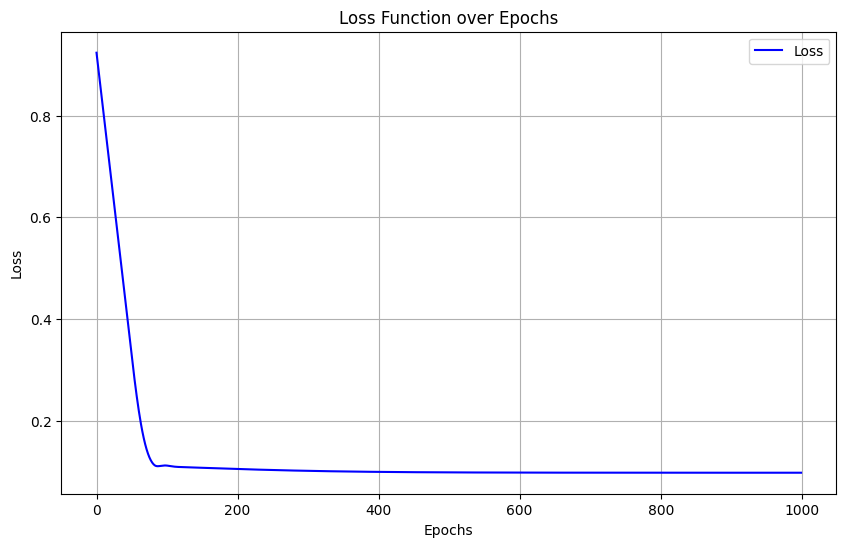

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(train_history, label='Loss', color='b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Model's testing

In [25]:
x_test, y_test = generate_data(f1, 100, 2)

In [26]:
test_result = test_model(model, criterion, x_test, y_test)
test_result

/usr/local/lib/python3.11/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


0.09822400659322739

# Function to extract model's parameters

In [27]:
def extract_model_params(model):
    """
        Extract's model's parameters (weights and biases for each layer)
        
        @param    model the model from which parameters will be extracted
        
        @returns  tuple of 4 numpy.ndarray: bias-1, weights-1 (for all the inputs; 
                  it can be a 1D or 2D tensor depending on the number of NN inputs), 
                  bias-2 and weights-2 (numer at the end represents layer).
    """
    # detach() - takes the required params and turns them into a numpy.ndarray
    # flatten() - flattens multidimensional tensors into 1D tensor
    b1 = model.input_hidden_layer.bias.detach().numpy() 
    w1 = model.input_hidden_layer.weight.detach().numpy()
    b2 = model.output_layer.bias.detach().numpy() 
    w2 = model.output_layer.weight.detach().numpy().flatten()
    
    return b1, w1, b2, w2

In [28]:
b1, w1, b2, w2 = extract_model_params(model)
b1.shape, w1.shape, b2.shape, w2.shape

((20,), (20, 2), (1,), (20,))

# Function of numerical integration based on model's parameters

In [29]:
def get_NN_integral(alpha1, alpha2, beta1, beta2, b1, w1, b2, w2):
    """
    Function that implements the new analytical integral based on the provided formulae.
    
    @param alpha1  Lower limit of integration for the first dimension
    @param alpha2  Lower limit of integration for the second dimension
    @param beta1   Upper limit of integration for the first dimension
    @param beta2   Upper limit of integration for the second dimension
    @param b1      Shifts between input and hidden layers
    @param w1      Weights between input and hidden layers
    @param b2      Shifts between hidden and output layers
    @param w2      Weights between hidden and output layers

    @returns       The analytical integral based on the neural network parameters.
    """
    
    def Phi_j(alpha1, alpha2, beta1, beta2, b1_j, w1_j):
        """
        Nested function implementing the difference of polylogarithms as defined in the new formula.
        
        @param alpha1  Lower limit of integration for the first dimension
        @param alpha2  Lower limit of integration for the second dimension
        @param beta1   Upper limit of integration for the first dimension
        @param beta2   Upper limit of integration for the second dimension
        @param b1_j    j-th shift between input and hidden layers
        @param w1_j    j-th weight between input and hidden layers
        @param w2_j    j-th weight between hidden and output layers
        
        @returns       Difference of polylogarithms as defined in the new formula.
        """
        w1_1j = w1_j[0]
        w1_2j = w1_j[1]

        term_alpha1_alpha1 = polylog(2, -np.exp(-b1_j - w1_1j * alpha1 - w1_2j * alpha1))  # Li_2 term for alpha1, alpha1
        term_alpha1_beta2  = polylog(2, -np.exp(-b1_j - w1_1j * alpha1 - w1_2j * beta2))   # Li_2 term for alpha1, beta2
        term_beta1_alpha2  = polylog(2, -np.exp(-b1_j - w1_1j * beta1 - w1_2j * alpha2))    # Li_2 term for beta1, alpha2
        term_beta1_beta2   = polylog(2, -np.exp(-b1_j - w1_1j * beta1 - w1_2j * beta2))     # Li_2 term for beta1, beta2
        
        return term_alpha1_alpha1 - term_alpha1_beta2 - term_beta1_alpha2 - term_beta1_beta2

    integral_sum = 0  # Sum of integrals
    
    # Sum over all j
    for w2_j, w1_j, b1_j in zip(w2, w1, b1):
        phi_j = Phi_j(alpha1, alpha2, beta1, beta2, b1_j, w1_j)  # Compute the difference of polylogarithms
        integral_sum += w2_j * ((beta1 - alpha1) * (beta2 - alpha2) + (phi_j / (w1_j[0] * w1_j[1])))  # Accumulate integral for sum
    
    # Final result based on the new formula
    return b2 * (beta1 - alpha1) * (beta2 - alpha2) + integral_sum  # Full formula result

# NNI evaluation

In [30]:
intgr = get_NN_integral(0.2, 0.2, 0.5, 0.5, b1, w1, b2, w2)
intgr

array([mpf('-14.95605489685466')], dtype=object)